In [3]:
import numpy as np
import matplotlib.pyplot as plt
import jsonpickle
import jsonpickle.ext.numpy as jsonpickle_numpy
import qctrlvisualizer as qv
jsonpickle_numpy.register_handlers()
import time
import qutip as qt
%matplotlib inline

waveform_path = "./"

# Hamiltonian Setting

In [4]:
# System parameters.
chi = -2 * np.pi * 70 * 1e3  # rad.Hz
K = -2 * np.pi * 0  # rad.Hz
delta = 0  # rad.Hz
delta_c = 0
alpha = -2 * np.pi * 246 * 1e6  # rad.Hz

transmon_dimension = 5  # Transmon dimensions.
cavity_dimension = 18  # Cavity dimensions.

qt_a = qt.tensor(qt.qeye(transmon_dimension), qt.destroy(cavity_dimension))
qt_b = qt.tensor(qt.destroy(transmon_dimension), qt.qeye(cavity_dimension))

sigz = - 2 * qt_b.dag() * qt_b + qt.tensor(qt.qeye(transmon_dimension), qt.qeye(cavity_dimension))
sigx = qt_b.dag() + qt_b
sigy = 1j * (qt_b.dag() - qt_b)

transmon_0_proj = qt.tensor(qt.basis(transmon_dimension, 0) * qt.basis(transmon_dimension, 0).dag() ,qt.qeye(cavity_dimension))
transmon_1_proj = qt.tensor(qt.basis(transmon_dimension, 1) * qt.basis(transmon_dimension, 1).dag() ,qt.qeye(cavity_dimension))
transmon_2_proj = qt.tensor(qt.basis(transmon_dimension, 2) * qt.basis(transmon_dimension, 2).dag() ,qt.qeye(cavity_dimension))
# transmon_3_proj = qt.tensor(qt.basis(transmon_dimension, 3) * qt.basis(transmon_dimension, 3).dag() ,qt.qeye(cavity_dimension))

cavity_0_proj = qt.tensor(qt.qeye(transmon_dimension), qt.basis(cavity_dimension, 0) * qt.basis(cavity_dimension, 0).dag())
cavity_1_proj = qt.tensor(qt.qeye(transmon_dimension), qt.basis(cavity_dimension, 1) * qt.basis(cavity_dimension, 1).dag())
cavity_2_proj = qt.tensor(qt.qeye(transmon_dimension), qt.basis(cavity_dimension, 2) * qt.basis(cavity_dimension, 2).dag())
cavity_3_proj = qt.tensor(qt.qeye(transmon_dimension), qt.basis(cavity_dimension, 3) * qt.basis(cavity_dimension, 3).dag())
cavity_4_proj = qt.tensor(qt.qeye(transmon_dimension), qt.basis(cavity_dimension, 4) * qt.basis(cavity_dimension, 4).dag())
cavity_5_proj = qt.tensor(qt.qeye(transmon_dimension), qt.basis(cavity_dimension, 5) * qt.basis(cavity_dimension, 5).dag())
cavity_6_proj = qt.tensor(qt.qeye(transmon_dimension), qt.basis(cavity_dimension, 6) * qt.basis(cavity_dimension, 6).dag())
cavity_7_proj = qt.tensor(qt.qeye(transmon_dimension), qt.basis(cavity_dimension, 7) * qt.basis(cavity_dimension, 7).dag())
cavity_8_proj = qt.tensor(qt.qeye(transmon_dimension), qt.basis(cavity_dimension, 8) * qt.basis(cavity_dimension, 8).dag())
cavity_9_proj = qt.tensor(qt.qeye(transmon_dimension), qt.basis(cavity_dimension, 9) * qt.basis(cavity_dimension, 9).dag())
cavity_10_proj = qt.tensor(qt.qeye(transmon_dimension), qt.basis(cavity_dimension, 10) * qt.basis(cavity_dimension, 10).dag())


psi0 = qt.tensor(qt.basis(transmon_dimension, 0), qt.basis(cavity_dimension, 0))

qt_H_static = delta_c * qt_a.dag() * qt_a + K / 2 * qt_a.dag() * qt_a.dag() * qt_a * qt_a + alpha / 2 * qt_b.dag() * qt_b.dag() * qt_b * qt_b + chi * qt_a.dag() * qt_a * qt_b.dag() * qt_b
qt_H_static = qt_H_static / 1e9 # changing the unit to GHz

# Simulation

In [8]:
# Read and write helper functions, type independent.
def save_variable(file_name, var):
    """
    Save a single variable to a file using jsonpickle.
    """
    with open(file_name, "w+") as file:
        file.write(jsonpickle.encode(var))


def load_variable(file_name):
    """
    Load a variable from a file encoded with jsonpickle.
    """
    with open(file_name, "r+") as file:
        return jsonpickle.decode(file.read())

two_pi = 2 * np.pi

def get_time():
    return " "+time.strftime(r'%Y-%m-%d %H-%M-%S',time.localtime())


def generate_drive_from_array(complex_array, dt=1):
    out=[]
    for d in complex_array:
        for i in range(dt):
            out.append(d)
    
    return np.array(out)

def plot_pulse(qubit_control, cavity_control, figsize=(10,8), control_name="QOC pulse"):
    fig, ax  = plt.subplots(2,1, figsize=figsize)
    ax[0].plot(np.real(qubit_control) / (two_pi) * 1e3, label="transmon I")
    ax[0].plot(np.imag(qubit_control) / (two_pi) * 1e3, label="transmon Q")
    ax[1].plot(np.real(cavity_control) / (two_pi) * 1e3, label="cavity I")
    ax[1].plot(np.imag(cavity_control) / (two_pi) * 1e3, label="cavity Q")
    ax[0].set_xlabel("Time (ns)")
    ax[1].set_xlabel("Time (ns)")
    ax[0].set_ylabel("$\\Omega/2\pi$ (MHz)")
    ax[1].set_ylabel("$\\epsilon/2\pi$ (MHz)")
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='upper right')
    ax[0].axhline(y=0, color='black')
    ax[0].grid()
    ax[1].axhline(y=0, color='black')
    ax[1].grid()
    ax[0].set_title(control_name);
    fig.tight_layout()

def system_dynamics(free_hamiltonian, qubit_control, cavity_control):
    tlist = np.linspace(0, len(qubit_control)-1, len(qubit_control))

    qt_transmon_I_drive_func = qt.coefficient(np.real(qubit_control), tlist=tlist)
    qt_transmon_Q_drive_func = qt.coefficient(np.imag(qubit_control), tlist=tlist)
    qt_cavity_I_drive_func = qt.coefficient(np.real(cavity_control), tlist=tlist)
    qt_cavity_Q_drive_func = qt.coefficient(np.imag(cavity_control), tlist=tlist)

    qt_H_transmon_I = [(qt_b + qt_b.dag()) , qt_transmon_I_drive_func]
    qt_H_transmon_Q = [-1j * (qt_b - qt_b.dag()) , qt_transmon_Q_drive_func]
    qt_H_cavity_I = [(qt_a + qt_a.dag()) / 2, qt_cavity_I_drive_func]
    qt_H_cavity_Q = [-1j * (qt_a - qt_a.dag()) / 2, qt_cavity_Q_drive_func]

    qt_H_total = [free_hamiltonian, qt_H_transmon_I, qt_H_transmon_Q, qt_H_cavity_I, qt_H_cavity_Q]
    options = qt.Options(rtol=1e-12, atol=1e-12, nsteps = 1000000, store_states = True)
    e_ops = [qt_a.dag() * qt_a, qt_b.dag() * qt_b, sigx, sigy, sigz, transmon_0_proj, transmon_1_proj, transmon_2_proj, cavity_0_proj, cavity_1_proj, cavity_2_proj, cavity_3_proj, cavity_4_proj, cavity_5_proj, cavity_6_proj, cavity_7_proj,cavity_8_proj,cavity_9_proj, cavity_10_proj]

    psi0 = qt.tensor(qt.basis(transmon_dimension, 0), qt.basis(cavity_dimension, 0))
    res = qt.mesolve(qt_H_total, psi0, tlist, e_ops=e_ops, options=options)

    return tlist, res

def extract_results(res):
    cavity_population = res.expect[0]
    transmon_population = res.expect[1]
    sigx_exp = res.expect[2]
    sigy_exp = res.expect[3]
    sigz_exp = res.expect[4]
    transmon_0_exp = res.expect[5]
    transmon_1_exp = res.expect[6]
    transmon_2_exp = res.expect[7]
    cavity_0_exp = res.expect[8]
    cavity_1_exp = res.expect[9]
    cavity_2_exp = res.expect[10]
    cavity_3_exp = res.expect[11]
    cavity_4_exp = res.expect[12]
    cavity_5_exp = res.expect[13]
    cavity_6_exp = res.expect[14]
    cavity_7_exp = res.expect[15]
    cavity_8_exp = res.expect[16]
    cavity_9_exp = res.expect[17]
    cavity_10_exp = res.expect[18]

    results ={
        "transmon_n": transmon_population,
        "cavity_n": cavity_population,
        "transmon x": sigx_exp,
        "transmon y": sigy_exp,
        "transmon z": sigz_exp,
        "transmon g": transmon_0_exp,
        "transmon e": transmon_1_exp,
        "transmon f": transmon_2_exp,
        "cavity 0": cavity_0_exp,
        "cavity 1": cavity_1_exp,
        "cavity 2": cavity_2_exp,
        "cavity 3": cavity_3_exp,
        "cavity 4": cavity_4_exp,
        "cavity 5": cavity_5_exp,
        "cavity 6": cavity_6_exp,
        "cavity 7": cavity_7_exp,
        "cavity 8": cavity_8_exp,
        "cavity 9": cavity_9_exp,
        "cavity 10": cavity_10_exp
    }

    return results

# 40 ns Robust Y90 gate from Yunwei and Qctrl 

<IPython.core.display.Javascript object>

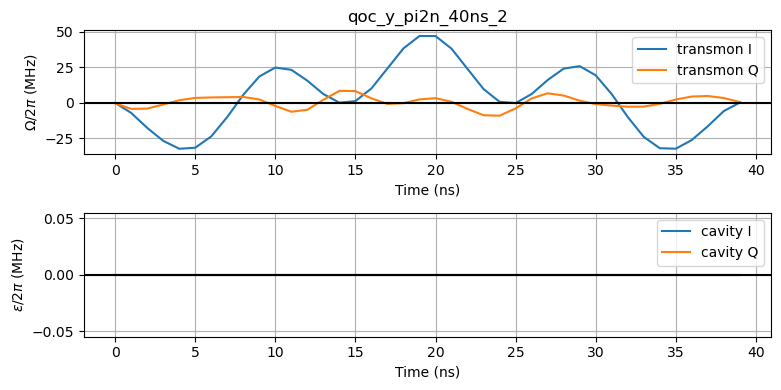

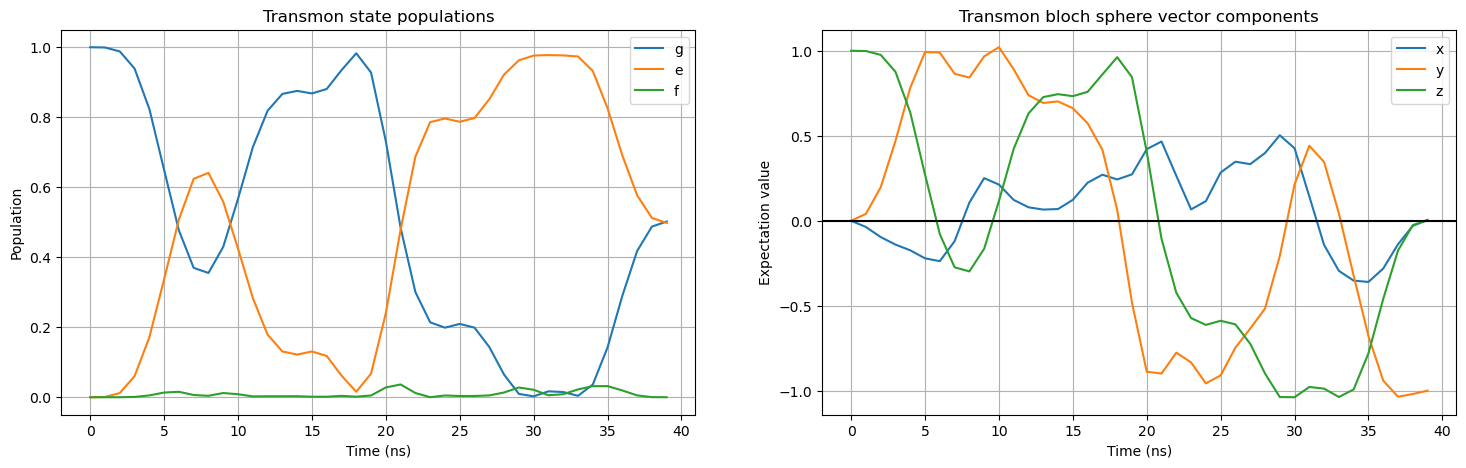

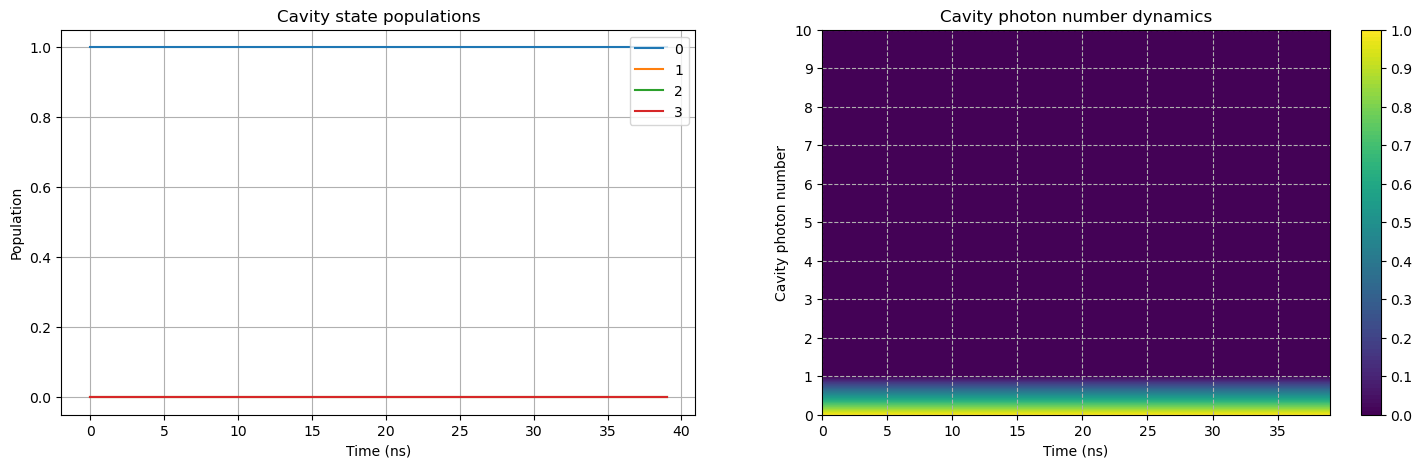

In [9]:
fname = "qoc_y_pi2n_40ns_2"
robust_dephasing_controls = load_variable(waveform_path+fname)
data = (robust_dephasing_controls["output"]["$\\Omega L(\\I)$"]['values'] + 1j * robust_dephasing_controls["output"]["$\\Omega L(\Q)$"]['values'])/ 1e9

data_dt = 1

qt_transmon_drive = generate_drive_from_array(data, data_dt)
qt_cavity_drive = np.zeros_like(qt_transmon_drive)

plot_pulse(qt_transmon_drive, qt_cavity_drive, control_name=fname, figsize=(8,4))

qt_tlist, qt_results = system_dynamics(qt_H_static, qt_transmon_drive, qt_cavity_drive)
results_dict = extract_results(qt_results)

qubit_g_population = results_dict["transmon g"]
qubit_e_population = results_dict["transmon e"]
qubit_f_population = results_dict["transmon f"]
qubit_x = results_dict["transmon x"]
qubit_y = results_dict["transmon y"]
qubit_z = results_dict["transmon z"]

fig, ax = plt.subplots(1,2, figsize=(18,5))
ax[0].plot(qt_tlist, qubit_g_population, label="g")
ax[0].plot(qt_tlist, qubit_e_population, label="e")
ax[0].plot(qt_tlist, qubit_f_population, label="f")
ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("Population")
ax[0].legend(loc='upper right')
ax[0].grid()
ax[0].set_title("Transmon state populations")
ax[1].plot(qt_tlist, qubit_x, label="x")
ax[1].plot(qt_tlist, qubit_y, label="y")
ax[1].plot(qt_tlist, qubit_z, label="z")
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("Expectation value")
ax[1].grid()
ax[1].legend(loc='upper right')
ax[1].set_title("Transmon bloch sphere vector components")
ax[1].axhline(y=0, color='black')

cavity_0 = results_dict["cavity 0"]
cavity_1 = results_dict["cavity 1"]
cavity_2 = results_dict["cavity 2"]
cavity_3 = results_dict["cavity 3"]
cavity_4 = results_dict["cavity 4"]
cavity_5 = results_dict["cavity 5"]
cavity_6 = results_dict["cavity 6"]
cavity_7 = results_dict["cavity 7"]
cavity_8 = results_dict["cavity 8"]
cavity_9 = results_dict["cavity 9"]
cavity_10 = results_dict["cavity 10"]

fig, ax = plt.subplots(1,2, figsize=(18,5))
ax[0].plot(qt_tlist, cavity_0, label="0")
ax[0].plot(qt_tlist, cavity_1, label="1")
ax[0].plot(qt_tlist, cavity_2, label="2")
ax[0].plot(qt_tlist, cavity_3, label="3")
ax[0].legend(loc='upper right')
ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("Population")
ax[0].grid()
ax[0].set_title("Cavity state populations")
cavity_photon_prob = [cavity_0, cavity_1, cavity_2, cavity_3, cavity_4, cavity_5, cavity_6, cavity_7, cavity_8, cavity_9, cavity_10]
cavity_photon_list = np.linspace(0, len(cavity_photon_prob)-1, len(cavity_photon_prob))
levs = np.linspace(0, 1, 100)
plot1 = ax[1].contourf(qt_tlist, cavity_photon_list, cavity_photon_prob, levs, cmap='viridis')
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("Cavity photon number")
ax[1].set_title("Cavity photon number dynamics")
ax[1].grid(linestyle='--')
ax[1].set_yticks(np.linspace(0,10,11))
cl_bar = plt.colorbar(plot1)
cl_bar.set_ticks(np.arange(0,1+0.1,0.1))

bloch_vector_array = np.array([qubit_x, qubit_y, qubit_z]).transpose()

qv.display_bloch_sphere_from_bloch_vectors(bloch_vector_array)